# Solution Planning

## Business Problem

**Qual é o problema de negócios?**
1. Selecionar os clientes mais valiosos para integrar o programa de fidelidade "Loyals".

2. Responder a questões de negócio ao time de marketing.

### Output

**O que vou entregar? / Onde o time de negócio quer ver?**

* 1) Lista em xls / enviar por email. Deve conter clientes que irão aderir ao Loyals (programa de fidelidade). 
   - Formato:
   
| client_id | is_loyal |
|-----------|----------|
|1          |yes       |
|2          |no        |

* 2) Relatório em pdf respondendo as questões de negócio / enviar por email e apresentar ao time de marketing:
    - Quem são as pessoas elegíveis para participar do programa Loyals?
    - Quantos clientes farão parte do grupo?
    - Quais são as principais características desses clientes?
    - Qual a porcentagem de contribuição de faturamento, vinda do Loyals?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Loyals? 
    - Quais as condições para uma pessoa ser removida do Loyals?
    - Qual a garantia que o programa Loyals é melhor que o restante da base?
    - Quais ações do time de marketing pode realizar para aumentar o faturamento?

### Input

**Fontes de dados:**
    Dataset "Ecommerce.csv", contendo as vendas de e-commerce do período de um ano.

**Ferramentas:**
    Python 3.8.12, Jupyter Notebook, Git, Github.

### Process

**Tipo de problema:**
Separação de clientes por grupos.
    
**Principais métodos:**
    Clusterização.

**Perguntas de negócio:**
* 1) Quem são as pessoas elegíveis para participar do programa Loyals?
    - O que é ser elegível? / O que são clientes de maior "valor"? (de acordo com área de negócio) 
        - Faturamento:
             - Alto ticket médio
             - Alto LTV (soma da receita do cliente conosco)
             - Baixa recência (tempo desde a última compra)
             - Alto basket size (qtd produtos comprados por compra)
             - Baixa probabilidade de churn (usaria a saída de um modelo)
             - Alta Previsão LTV (usaria saída de um modelo)
             - Alta propensão de compra (usaria a saída de um modelo)
        - Custo:
             - Baixa taxa de devolução
        - Experiência de compra:
             - Média alta das avaliações

 PS: as features acima serão criadas no feature engeneering. 
 
 
* 2) Quantos clientes farão parte do grupo?
    - Número de clientes
    - % em relação ao total de clients
    
    
* 3) Quais são as principais características desses clientes?
    - Escrever caracterísiticas do cliente:
        - Idade
        - País
        - Salário
        - Localização
     - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide features da clusterização (questão 1)
         
 Para look alike: prospectar clientes parecidos na internet


* 4) Qual a porcentagem de contribuição de faturamento, vinda do Loyals?
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Loyals.   
   
   
* 5) Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Cálculo do LTV do Loyals (com média móvel, time series, arima..)
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    - Análise de Cohort (com tempo, localização, produto..)       

 Deve haver meta de faturamento, consultar negócio.
    
    
* 6) Quais as condições para uma pessoa ser elegível ao Loyals?
    - Definir o período de avaliação (a cada 1 mês, 3 meses..)
    - O "desempenho" do cliente deve estar próximo da média do cluster Loyals.
    
    
* 7) Quais as condições para uma pessoa ser removida do Loyals?
    - O "desempenho" do cliente não está mais próximo da média do cluster Loyals. 
   
   
* 8) Qual a garantia que o programa Loyals é melhor que o restante da base?
    - Teste A/B
    - Teste de hipótese


* 9) Quais ações do time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete mais barato
    - Visita a empresa
    - Oferecer personal stylist
    - Recomendar cross sell 
    - Oferecer conteúdo expclusivo

## Solution Benchmarking

### Desk Research

Leitura de artigos sobre customer segmentation na internet, para compreender o que o mercado está fazendo.

Identificar a partir das soluções do mercado, com o time de negócio, o que podemos fazer como MVP.

1. Modelo RFM de segmentação.

# Environment Preparation

## Imports

In [5]:
import pandas            as pd
import seaborn           as sns
import datetime          as dt
import umap.umap_        as umap

from matplotlib               import pyplot as plt
from tabulate                 import tabulate
from IPython.core.display     import HTML
from sklearn                  import cluster as c
from sklearn                  import metrics as m
from yellowbrick.cluster      import KElbowVisualizer, SilhouetteVisualizer
from plotly                   import express as px
#from IPython.display         import Image

## Helper Functions

In [6]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
    sns.set()
jupyter_settings()

# Data Collection

In [4]:
#read data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [6]:
df_raw = df_raw.drop('Unnamed: 8', axis=1).copy()
df_raw.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
185427,552816,22698,PINK REGENCY TEACUP AND SAUCER,3,9-May-17,2.95,15521.0,United Kingdom
275769,561009,23158,SET OF 5 LUCKY CAT MAGNETS,12,20-Jul-17,2.08,15856.0,United Kingdom
123973,546928,22820,GIFT BAG BIRTHDAY,12,16-Mar-17,0.65,17685.0,United Kingdom


# Data Description

In [7]:
df1 = df_raw.copy()

## Rename Columns

In [8]:
df1.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
302445,563431,23144,ZINC T-LIGHT HOLDER STARS SMALL,12,14-Aug-17,0.83,16266.0,United Kingdom
394329,570871,85032A,ROMANTIC IMAGES GIFT WRAP SET,2,10-Oct-17,1.63,NaN,United Kingdom
307422,563917,21121,SET/10 RED POLKADOT PARTY CANDLES,2,19-Aug-17,1.25,14572.0,United Kingdom


In [9]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## Feature Description 

In [11]:
# Explain feature meanings
tab_meanings = [['Columns', 'Meaning'],
        ['invoice_no', 'unique identifier of each transaction'],
        ['stock_code', 'item code'],
        ['description', 'item name'],
        ['quantity', 'quantity of each item purchased per transaction'],
        ['invoice_date', 'the day the transaction took place'],
        ['unit_price', 'product price per unit'],
        ['customer_id', 'unique customer identifier'],
        ['country', 'customer\'s country of residence']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='simple'))

Columns       Meaning
------------  -----------------------------------------------
invoice_no    unique identifier of each transaction
stock_code    item code
description   item name
quantity      quantity of each item purchased per transaction
invoice_date  the day the transaction took place
unit_price    product price per unit
customer_id   unique customer identifier
country       customer's country of residence


In [12]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
188057,553013,23110,PARISIENNE KEY CABINET,1,10-May-17,12.46,NaN,United Kingdom
477752,577076,20983,12 PENCILS TALL TUBE RED RETROSPOT,4,15-Nov-17,0.85,14362.0,United Kingdom
248961,558877,84692,BOX OF 24 COCKTAIL PARASOLS,4,2-Jul-17,0.42,17841.0,United Kingdom


## Data Dimensions

In [13]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Check NA

In [15]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [16]:
#remove rows with NA
df1 = df1.dropna( subset=['description','customer_id'] )

In [17]:
print (f'Removed data: { 1-(df1.shape[0] / df_raw.shape[0]):.2f}%')

Removed data: 0.25%


In [18]:
df1.tail()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,7-Dec-17,4.95,12680.0,France


In [19]:
#reset index
df1 = df1.reset_index(drop=True)

In [20]:
#new num of rows
df1.shape

(406829, 8)

In [21]:
#check
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## Change Types

In [22]:
#correct data types ensure correct calculations using the columns on next sessions

In [23]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [24]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
136066,553476,23298,SPOTTY BUNTING,3,15-May-17,4.95,14221.0,United Kingdom
209269,562453,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,24,3-Aug-17,1.25,18097.0,United Kingdom
9739,537429,22355,CHARLOTTE BAG SUKI DESIGN,4,4-Dec-16,0.85,12748.0,United Kingdom


In [25]:
#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

In [26]:
#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [27]:
# invoice_no
#df1['invoice_no'] = df1['invoice_no'].astype(int)
#there are letters on invoice, so let it like object(string). Ex: 'C536379', 'C554197'

In [28]:
# stock_code
#df1['stock_code'] = df1['stock_code'].astype(int)
#there are letters on stock_code, so let it like object(string). Ex: '85123A', '84406B'

In [29]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
87424,547375,21506,"FANCY FONT BIRTHDAY CARD,",12,2017-03-20,0.42,13196,United Kingdom
80613,546562,22798,ANTIQUE GLASS DRESSING TABLE POT,8,2017-03-13,2.95,16293,United Kingdom
218703,563538,21123,SET/10 IVORY POLKADOT PARTY CANDLES,4,2017-08-15,1.25,17841,United Kingdom


In [30]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [31]:
#pass on first cycle
pass

# Feature Engeneering

## Feature Creation

In [92]:
#save dataset
#df1.to_csv("../data/interim/df1_data_description_done.csv")

In [33]:
df2 = pd.read_csv("../data/interim/df1_data_description_done.csv", index_col=0, parse_dates=['invoice_date'])
df2.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
381335,579001,22384,LUNCH BAG PINK POLKADOT,4,2017-11-25,1.65,15555,United Kingdom
331422,574550,85123A,WHITE HANGING HEART T-LIGHT HOLDER,4,2017-11-02,2.95,12484,Spain
133906,553184,22098,BOUDOIR SQUARE TISSUE BOX,3,2017-05-13,1.25,13232,United Kingdom


In [34]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [35]:
# our current granularity is: stock_code + invoice_date
# we need to have customer as granularity, to have is's features on a new table.
# let's start adjusting the dataset to build an RFM Segmentation Model (Recency, Frequency, Monetary Value)

In [36]:
#get first customer as sample
df2.loc[ df2['invoice_no'] == '536365']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2016-11-29,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2016-11-29,4.25,17850,United Kingdom


In [37]:
#create the referente table with uniques customer_id (and reset index)
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True).copy()

In [38]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [39]:
#let's now create the 3 variables needed to use the RFM Segmentation Model 

### gross_revenue

In [40]:
# Gross Revenue: (quantity * price of each purchase)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']
df2.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
77541,546215,21929,JUMBO BAG PINK VINTAGE PAISLEY,2,2017-03-08,1.95,14713,United Kingdom,3.90
310140,572475,23473,WOODLAND SMALL RED FELT HEART,1,2017-10-22,0.83,15271,United Kingdom,0.83
48979,542789,21165,BEWARE OF THE CAT METAL SIGN,48,2017-01-30,1.45,17511,United Kingdom,69.60


In [41]:
# df_monetary = gorss_revenue by customer
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary

,customer_id,gross_revenue
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4367,18280,180.60
4368,18281,80.82
4369,18282,176.60
4370,18283,2094.88


In [42]:
#merge df_ref + df_monetary
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

In [43]:
#check possible join problems
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

In [44]:
#reference table of customer_id with first var
df_ref.head()

,customer_id,gross_revenue
0,17850,5288.63
1,13047,3079.10
2,12583,7187.34
3,13748,948.25
4,15100,635.10


### recency

In [45]:
# Recency: number of days since last purchase

In [46]:
# get each customer's last day of purchase 
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency.head()

,customer_id,invoice_date
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [47]:
#'2017-12-07' is the last day with purchases on this dataset. 
# Let's assume '2017-12-07' is today, avoiding big distortions. Using updated dataset, last purchase would be recent (dataset is 4y/o +).
# In real cases, this variable would be dt.date.today(), and could be updated daily.
today = df2['invoice_date'].max()
today

Timestamp('2017-12-07 00:00:00')

In [48]:
#Calculate number of days since last purchase
#"today" (being '2017-12-07') - invoice_date (last day of purchase of each customer)
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency

,customer_id,invoice_date,recency_days
0,12346,2017-01-16,325
1,12347,2017-12-05,2
2,12348,2017-09-23,75
3,12349,2017-11-19,18
4,12350,2017-01-31,310
...,...,...,...
4367,18280,2017-03-05,277
4368,18281,2017-06-10,180
4369,18282,2017-11-30,7
4370,18283,2017-12-04,3


In [49]:
#check recency days (2017-12-07 -> 2017-01-16) = 325 days
df2['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [50]:
df_recency

,customer_id,invoice_date,recency_days
0,12346,2017-01-16,325
1,12347,2017-12-05,2
2,12348,2017-09-23,75
3,12349,2017-11-19,18
4,12350,2017-01-31,310
...,...,...,...
4367,18280,2017-03-05,277
4368,18281,2017-06-10,180
4369,18282,2017-11-30,7
4370,18283,2017-12-04,3


In [51]:
#drop invoice_date (max purchase date) from df_recency
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_recency

,customer_id,recency_days
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310
...,...,...
4367,18280,277
4368,18281,180
4369,18282,7
4370,18283,3


In [52]:
# merge df_recency w/ df_ref
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref

,customer_id,gross_revenue,recency_days
0,17850,5288.63,302
1,13047,3079.10,31
2,12583,7187.34,2
3,13748,948.25,95
4,15100,635.10,330
...,...,...,...
4367,13436,196.89,1
4368,15520,343.50,1
4369,13298,360.00,1
4370,14569,227.39,1


In [53]:
#check NA
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
dtype: int64

### frequency

In [54]:
# Frequency (number of purchases)

In [55]:
#check customer_id and invoice_no
#there are many duplicated invoices per customer
df2[['customer_id','invoice_no']].head(10)

,customer_id,invoice_no
0,17850,536365
1,17850,536365
2,17850,536365
3,17850,536365
4,17850,536365
5,17850,536365
6,17850,536365
7,17850,536366
8,17850,536366
9,13047,536367


In [56]:
#create new dataset with customer_id and invoice_no
#drop duplicates() to get count just one duplicate per customer
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_freq.head()

,customer_id,invoice_no
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [57]:
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [58]:
#check NAs
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
dtype: int64

### average ticket

In [72]:
# average gross revenue customers spend on all purchases
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


In [73]:
#check NAs
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# Variable Filtering

In [74]:
df2.to_csv("../data/interim/cy2_df2_feature_engineering_done.csv")
df_ref.to_csv("../data/interim/cy2_df_ref_done.csv")

In [7]:
#df3 = df_ref
df3 = pd.read_csv("../data/interim/cy2_df_ref_done.csv", index_col=0)
df3.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
invoice_no         int64
avg_ticket       float64
dtype: object

In [8]:
#three needed vars created, no filtering needed
pass

# EDA

In [9]:
#pass by now
df4 = df3.copy()

# Data Preparation

In [10]:
#pass by now
df5 = df4.copy()

# Feature Selection

In [11]:
#pass by now
df6 = df5.copy()

# Hyperparameter Fine-Tuning

In [13]:
#drop customer_id
X = df6.drop('customer_id', axis=1).copy()
X.head()
#agora, temos 4 variáveis:

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


For a good clustering, we need clusters to have two properties:

- Compactness: smallest possible distance between the points of the same cluster.
- Separation: greatest possible distance between the points of different clusters.

Let's use k-means with 2 metrics: 

1 - Within-Cluster Sum of Square (WSS) - calculates Compactness 

2 - Silhouette Score (SS) - calculates Compactness and Separation

 


## Within-Cluster Sum of Square (WSS)

In [14]:
#up to 7 possible clusters now
clusters = [2, 3, 4, 5, 6, 7]

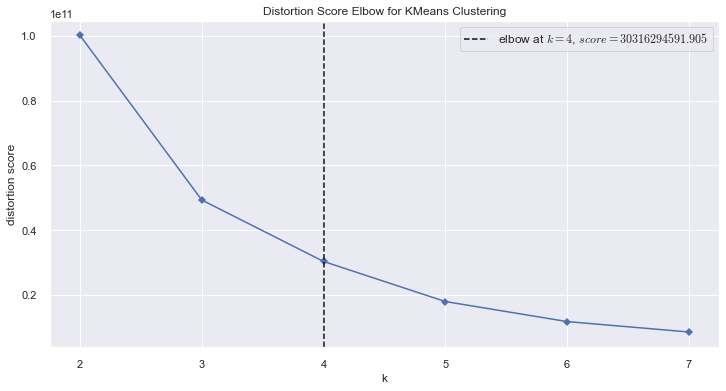

In [15]:
#let's use yellowbrick library, that inherits some functions from sklearn, and makes it easier to use performance metrics like WSS and SS
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show();
#it will sugest the number of clusters (dotted lines)

In [16]:
#The smaller the WSS, the smaller the sum of the distances within the clusters, which means that the points are closer to their centroid, so the cluster is more compact!

#even though with more cluster (5, 6, 7), we would have (a bit) more condensed clusters, the optimized number of clusters according to WSS is now 4 3.

## Silhouette Score

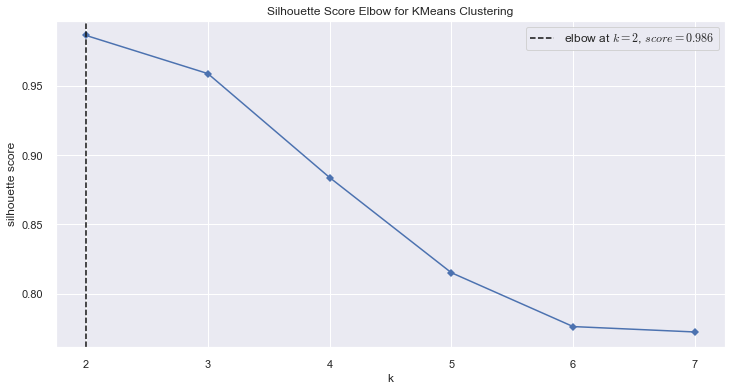

In [23]:
#calculate silhouette score also with yellowbrick library
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

In [18]:
#being SS=1 the best clustering result:
    # with 2 clusters, the result is 0.99 (awesome)
    # with 3 clusters, it is 0,96 (awesome)
    # with 4, or 5, we still have SS > 0.8, it's still very good!

#according to SS, the ideal cluster number is 2, but for business porposes, it's interesting to have at least 3 groups of customers, to be able to put actions on each of them. 

# Silhouette Analysis

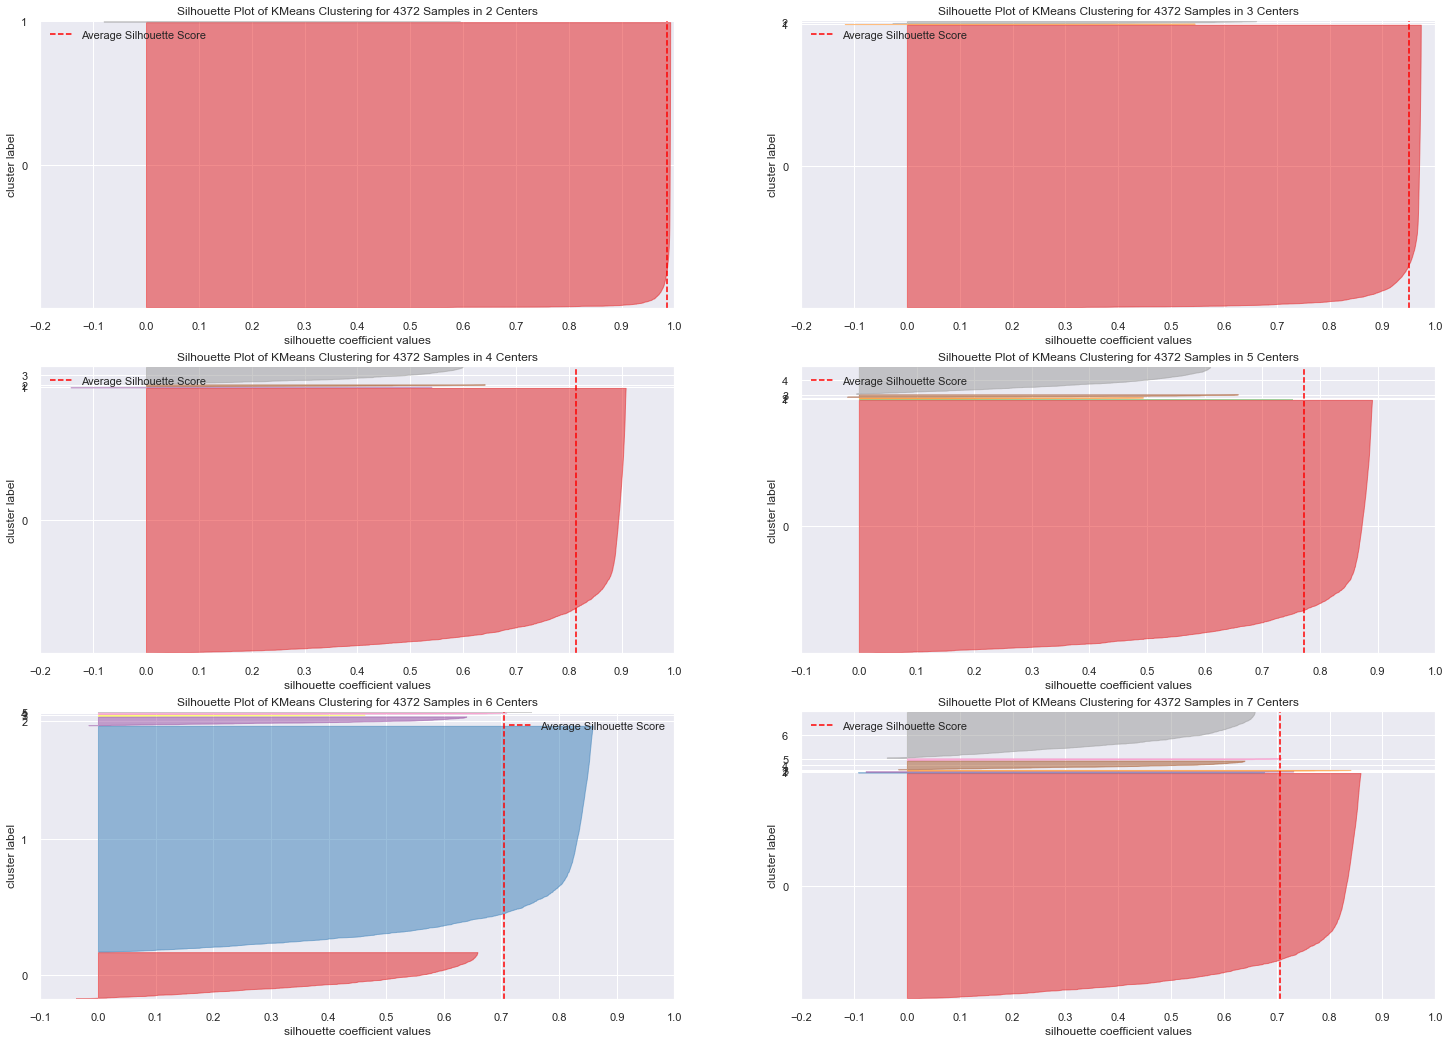

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    #run kmeans
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    #build positions to plot
    q, mod = divmod(k, 2)
    #plot silhouette
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    #plot silhouette analysis
    visualizer.fit(X)
    visualizer.finalize() #centers = clusters

In [ ]:
#with our features, our data is too grouped, and it's generating a cluster too big! It's absorving other minors.
#so, we can't define the best number of clusters by now. 
#But for this second cycle, let's keep on with k=4, as the SS sugested

# Model Training

## K-Means

In [21]:
# Let's then continue with the projectand train the k-means model with 4 clusters.

#model definition
k = 4
kmeans = c.KMeans( init='random', #init centroids ramdomly
                  n_clusters=k, #3
                  n_init=10, #Num of times k-means will be run with different centroid seeds.
                  max_iter=300, #up to 300 times
                 random_state=42) #seed, to generate the same random init
#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_
labels

array([3, 0, 3, ..., 0, 0, 0], dtype=int32)

## Cluster Validation

In [22]:
#Metric: WSS (Within-cluster sum of square)

#this method of k-means (sklearn) returns the WSS
print(f'WSS Value: {kmeans.inertia_}')

WSS Value: 40056506734.60243


In [24]:
#Metric: SS (Silhouette Score)

#this method of k-means (sklearn) returns the SS
print(f'SS Value: {m.silhouette_score(X, labels, metric="euclidean")}')

SS Value: 0.8139972028952444


In [ ]:
#the result for 4 clusters of SS=0.81 is in theory great!
#but, as can be seen on Silhouette Analysis, with 4 cluster, we have 1 that represents almost all data! 
#So, thats obvious it will perform well, because is't almost all the data of the dataset.

# Cluster Analysis

In [25]:
df9 = df6.copy()
#create a cluster column with labels of it's cluster from k-means, to be able to plot colored clusters
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## Visualization Inspection

/Users/home/opt/anaconda3/envs/pa005_clustering/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


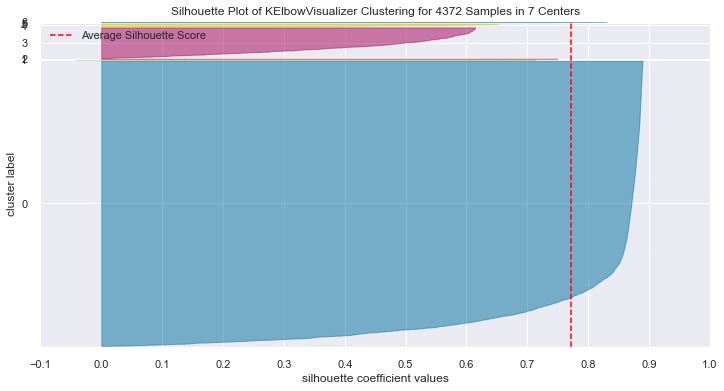

In [26]:
#there is no way to plot more than 3D charts, so let's use the Silhouette Plot
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

In [27]:
#chech wich features are messing up with the clustering, but it's not good do take a decision just looking at the plot, because two "bad" features combined, can turn into a "good" feature.a
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


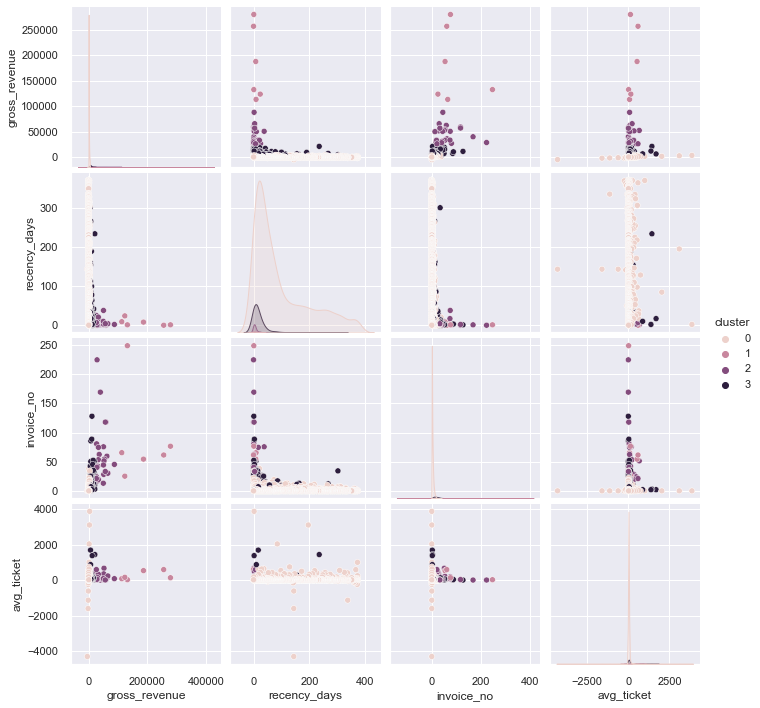

In [28]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## UMAP

In [29]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

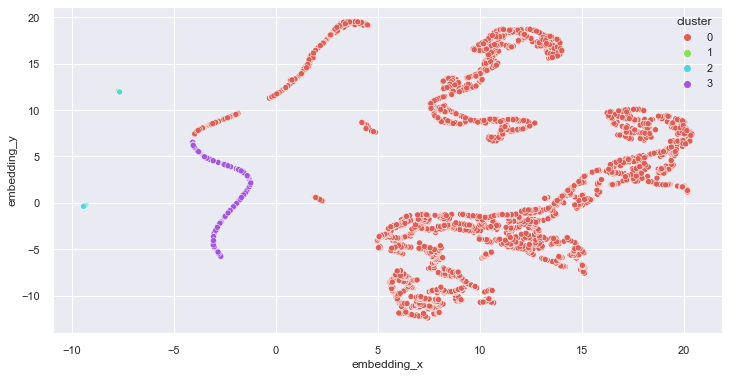

In [50]:
#n_neighbors=5

#reducer: high dimensionality projection
reducer = umap.UMAP( n_neighbors=8, #bigger: global structures, smaller: local structures (like a zoom!)
                    random_state=42 )
#fit variables in high dimensionality (x), projecting them in low dimensionality, generating the enbedding space
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0] #component 1
df_viz['embedding_y'] = embedding[:, 1] #component 2

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', #cluster color
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),# formula to get the number of clusters automatically)
                 data=df_viz )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

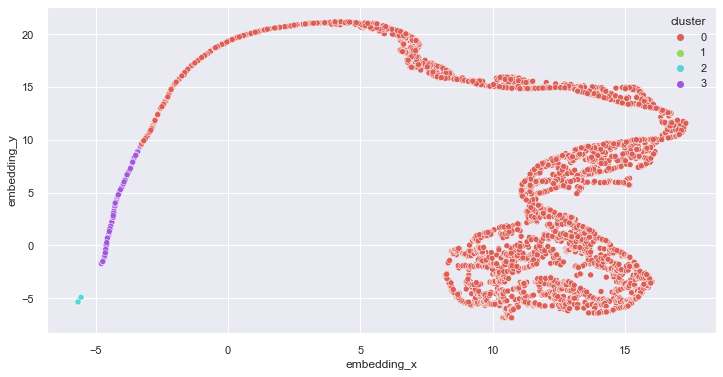

In [47]:
#n_neighbors=20

#reducer: high dimensionality projection
reducer = umap.UMAP( n_neighbors=20, #bigger: global structures, smaller: local structures (like a zoom!)
                    random_state=42 )
#fit variables in high dimensionality (x), projecting them in low dimensionality, generating the enbedding space
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0] #component 1
df_viz['embedding_y'] = embedding[:, 1] #component 2

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', #cluster color
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),# formula to get the number of clusters automatically)
                 data=df_viz )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

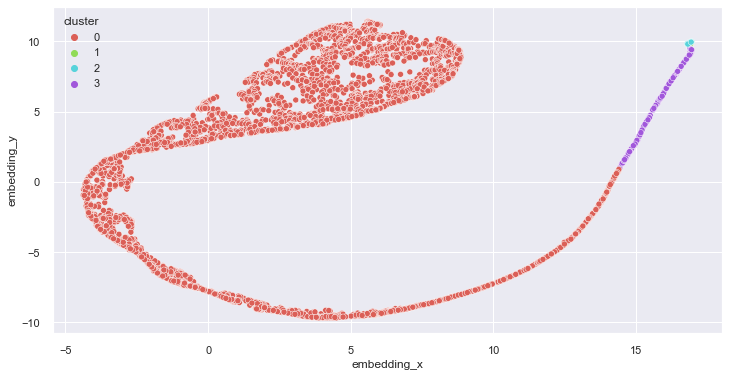

In [48]:
#n_neighbors=80

#reducer: high dimensionality projection
reducer = umap.UMAP( n_neighbors=80, #bigger: global structures, smaller: local structures (like a zoom!)
                    random_state=42 )
#fit variables in high dimensionality (x), projecting them in low dimensionality, generating the enbedding space
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0] #component 1
df_viz['embedding_y'] = embedding[:, 1] #component 2

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', #cluster color
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),# formula to get the number of clusters automatically)
                 data=df_viz )

In [39]:
embedding

array([[ 1.5085674e+01,  3.1784508e+00],
       [ 1.2432881e+01, -4.5517535e+00],
       [ 1.5960181e+01,  6.3112087e+00],
       ...,
       [ 4.4845767e+00,  5.6102042e+00],
       [ 7.7009635e+00,  6.4732275e+00],
       [-4.2745857e+00, -1.0516576e-02]], dtype=float32)

In [41]:
df_viz

,gross_revenue,recency_days,invoice_no,avg_ticket,cluster,embedding_x,embedding_y
0,5288.63,302,35,16.950737,3,15.085674,3.178451
1,3079.10,31,18,15.709694,0,12.432881,-4.551754
2,7187.34,2,18,28.634821,3,15.960181,6.311209
3,948.25,95,5,33.866071,0,-3.623408,-1.468295
4,635.10,330,6,105.850000,0,-0.030647,5.637376
...,...,...,...,...,...,...,...
4367,196.89,1,1,16.407500,0,8.199604,7.106347
4368,343.50,1,1,19.083333,0,5.037254,4.652588
4369,360.00,1,1,180.000000,0,4.484577,5.610204
4370,227.39,1,1,18.949167,0,7.700963,6.473228


## t-SNE

In [ ]:
#next cycles
pass

## Cluster Profile

In [52]:
#using 4 metrics, with avg_ticket to represent the centroid of the group (mean), let's understand who are the people inside each cluster

In [53]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


In [54]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id'] / df_cluster['customer_id'].sum()*100
df_cluster
#there is more than 99% of my customers in one cluster (0), so we need to work on features to improve this#

,cluster,customer_id,perc_customer
0,0,4071,93.115279
1,1,6,0.137237
2,2,28,0.640439
3,3,267,6.107045


In [55]:
# Agg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue
0,0,4071,93.115279,946.696250
1,1,6,0.137237,182181.981667
2,2,28,0.640439,42614.387143
3,3,267,6.107045,8089.028652


In [56]:
# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days
0,0,4071,93.115279,946.696250,96.969295
1,1,6,0.137237,182181.981667,7.166667
2,2,28,0.640439,42614.387143,6.178571
3,3,267,6.107045,8089.028652,20.280899


In [57]:
# Avg invoice number
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4071,93.115279,946.696250,96.969295,3.641120
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,28,0.640439,42614.387143,6.178571,57.821429
3,3,267,6.107045,8089.028652,20.280899,19.528090


In [58]:
# Avg invoice number
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


In [141]:
df_cluster = df_cluster.sort_values('customer_id', ascending=True) #sort by number of customers
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654


In [146]:
#generate the repport dinamically:
for i in range(len(df_cluster['customer_id'])):
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Number of customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i],1)}%)
    -Average revenue: ${round(df_cluster['gross_revenue'][i])}
    -Average recency: by each {round(df_cluster['recency_days'][i])} days ({round(df_cluster['recency_days'][i]/7)} week(s))
    -Average purchases: {round(df_cluster['invoice_no'][i])}  
    -Average ticket: ${round(df_cluster['avg_ticket'][i])} \n """)

 Cluster 0:
    -Number of customers: 4071 (93.1%)
    -Average revenue: $947
    -Average recency: by each 97 days (14 week(s))
    -Average purchases: 4  
    -Average ticket: $25 
 
 Cluster 1:
    -Number of customers: 6 (0.1%)
    -Average revenue: $182182
    -Average recency: by each 7 days (1 week(s))
    -Average purchases: 89  
    -Average ticket: $254 
 
 Cluster 2:
    -Number of customers: 28 (0.6%)
    -Average revenue: $42614
    -Average recency: by each 6 days (1 week(s))
    -Average purchases: 58  
    -Average ticket: $163 
 
 Cluster 3:
    -Number of customers: 267 (6.1%)
    -Average revenue: $8089
    -Average recency: by each 20 days (3 week(s))
    -Average purchases: 20  
    -Average ticket: $63 
 



**Cluster 1 (Loyal candidates)**
- Number of customers: 6 (0.1% of customers)
- Average revenue: $ 182,182.00
- Average recency: by each 7 days (1 weeks)
- Average purchases: 89 purchases

**Cluster 2**
- Number of customers: 31 (0.7% of customers)
- Average revenue: $ 40,543.00
- Average recency: by each 13 days (2 weeks)
- Average purchases: 52 purchases


**Cluster 3**
- Number of customers: 4335 (99% of customers)
- Average revenue: $ 1,372.00
- Average recency: by each 92 days (3 months)
- Average purchases: 5 purchases

# Deploy

In [145]:
#in the future